In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [14]:
import torch
import os
import pickle
import pandas as pd
import numpy as np
from modules.functions import pymatgen_comp, data_generator_vec, check_cuda
from sklearn.neighbors import KernelDensity
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt

In [4]:
model_path = 'saved_models'
if os.path.exists(os.path.join(model_path, 'GAN_generator.pt')):
    generator = torch.jit.load(os.path.join(model_path, 'GAN_generator.pt'), map_location='cpu')
else:
    print('train model first!')

el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y.pkl','rb') as fid:
    uts_scaler = pickle.load(fid)

In [7]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')

latent_dim = 4
cuda = check_cuda()

## directions of W and Hf variance

In [169]:
n_samples  =10000
uniform_noise = np.random.uniform(0,1, size = (n_samples, latent_dim)).astype('float32')
gen_input = torch.from_numpy(uniform_noise)
prop_input = prop_sampler(n_samples)
prop_input =  torch.from_numpy(prop_input)
if cuda:
        generator = generator.cuda()
        gen_input = gen_input.cuda()
        prop_input = prop_input.cuda()
g_fake_data = generator(gen_input,prop_input).to('cpu').detach().numpy()
uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data]
w_ind = np.argwhere(el_list == 'W').item()
hf_ind = np.argwhere(el_list == 'Hf').item()
w_content = g_fake_data[:,w_ind]
hf_content = g_fake_data[:,hf_ind]

In [170]:
from scipy.stats import pearsonr
for i in range(uniform_noise.shape[1]):
    print(f'W Correlation with dim {i+1} : {pearsonr(uniform_noise[:,i], w_content)[0]}')
    print(f'Hf Correlation with dim {i+1} : {pearsonr(uniform_noise[:,i], hf_content)[0]}')
    

W Correlation with dim 1 : -0.26901675708822176
Hf Correlation with dim 1 : -0.1925176751406234
W Correlation with dim 2 : 0.44894582858853227
Hf Correlation with dim 2 : 0.27585574917905814
W Correlation with dim 3 : -0.3561691865456788
Hf Correlation with dim 3 : -0.22045781573633855
W Correlation with dim 4 : 0.5515965557930276
Hf Correlation with dim 4 : 0.31414040825451717


In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(uniform_noise)
predicted_w, predicted_hf = [],[]
for i, (train_idx,test_idx) in enumerate(kf.split(uniform_noise)):
    X_train, y_train_w, y_train_hf = uniform_noise[train_idx], w_content[train_idx], hf_content[train_idx]
    X_test, y_test_w, y_test_hf = uniform_noise[test_idx],w_content[test_idx],hf_content[test_idx]
    LNRmodel_w, LNRmodel_hf = LinearRegression(), LinearRegression()
    LNRmodel_w.fit(X_train,y_train_w)
    LNRmodel_hf.fit(X_train,y_train_hf)
    y_pred_w = LNRmodel_w.predict(X_test)
    y_pred_hf = LNRmodel_hf.predict(X_test)
    predicted_w.append(pearsonr(y_pred_w,y_test_w)[0])
    predicted_hf.append(pearsonr(y_pred_hf,y_test_hf)[0])
print(f'Mean of W linear model : {np.mean(predicted_w)}, Std of W linear model : {np.std(predicted_w)}')
print(f'Mean of Hf linear model : {np.mean(predicted_hf)}, Std of Hf linear model : {np.std(predicted_hf)}')

Mean of W linear model : 0.842043600497477, Std of W linear model : 0.006203130201469051
Mean of Hf linear model : 0.5112190950733078, Std of Hf linear model : 0.01698562653679135


In [180]:
dominant_w_dir = LNRmodel_w.coef_
dominant_hf_dir = LNRmodel_hf.coef_
non_dominant_hf_dir = -1*dominant_hf_dir
new_direction = dominant_hf_dir + dominant_w_dir

unit_vector_w = unit_vector(dominant_w_dir)
unit_vector_hf = unit_vector(dominant_hf_dir)
inv_unit_vector_hf = unit_vector(non_dominant_hf_dir)

In [214]:
angle_between(unit_vector_w,dominant_w_dir)

0.0

In [216]:
new_unit = dominant_w_dir + non_dominant_hf_dir
new_unit_unit = unit_vector(new_unit)

unit_vec_add = unit_vector_w + inv_unit_vector_hf
angle_between(new_unit_unit,unit_vec_add)

1.5059472236321783

In [209]:
w_content_new = np.dot(uniform_noise,new_unit) + LNRmodel_w.intercept_
hf_content_new = np.dot(uniform_noise,new_unit) + LNRmodel_hf.intercept_
pearsonr(w_content_new,w_content), pearsonr(hf_content_new,hf_content)

((0.8415362326335194, 0.0), (0.5091611669125237, 0.0))

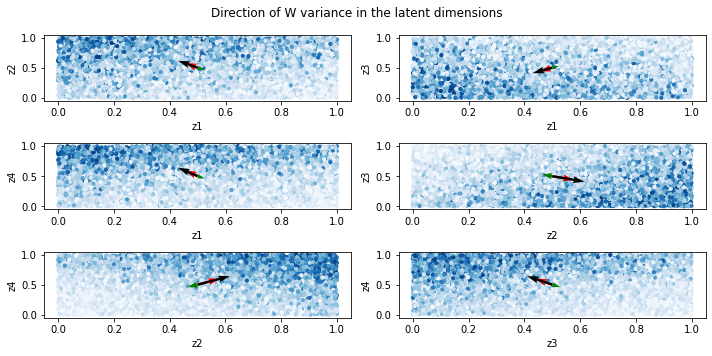

In [210]:
from itertools import combinations
perm = combinations(np.arange(uniform_noise.shape[1]), 2)  
fig,ax = plt.subplots(3,2,figsize = (10,5))
ax = ax.flatten()
for k,i in enumerate(list(perm)):
    a,b = i
    ax[k].scatter(uniform_noise[:,a],uniform_noise[:,b],s = 10, c = w_content[:],cmap = 'Blues')
    ax[k].quiver(0.5,0.5,new_unit[a],new_unit[b],angles='xy', scale_units='xy', scale=1, color = 'red')
    ax[k].quiver(0.5,0.5,dominant_w_dir[a],dominant_w_dir[b],angles='xy', scale_units='xy', scale=1)
    ax[k].quiver(0.5,0.5,non_dominant_hf_dir[a],non_dominant_hf_dir[b],angles='xy', scale_units='xy', scale=1, color = 'green')

    ax[k].set_xlabel('z{}'.format(a+1))
    ax[k].set_ylabel('z{}'.format(b+1))

plt.suptitle('Direction of W variance in the latent dimensions')
plt.tight_layout()

In [141]:
non_dominant_hf_dir = -1*dominant_hf_dir
non_dominant_hf_dir + dominant_w_dir.reshape(1,-1)

array([[-0.12663634,  0.20400839, -0.16434512,  0.2504069 ]],
      dtype=float32)

In [129]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

angle_between(dominant_hf_dir,dominant_w_dir)

3.130251216194681